In [1]:
import sys  ###graphslamlogger（下まで全部）
sys.path.append('../scripts/')
from robot import *

In [2]:
class LoggerAgent(Agent):
    def __init__(self, nu, omega, interval_time, init_pose): #更新時間と初期姿勢を変数に加える
        super().__init__(nu, omega)
        self.interval_time = interval_time
        self.pose = init_pose
        self.step = 0
        self.log = open("log.txt", "w")
        self.log.write("delta {}\n".format(interval_time))
        
    def decision(self, observation):
        self.log.write("x {} {} {} {}\n".format(self.step, *self.pose)) #時刻, x, y, theta
        
        for lm in observation:
            self.log.write("z {} {} {} {}\n".format(self.step, lm[1], *lm[0]))
        
        self.pose = IdealRobot.state_transition(self.nu, self.omega, self.interval_time, self.pose)
        self.step += 1
        
        self.log.write("u {} {} {}\n".format(self.step, self.nu, self.omega))
        self.log.flush()
        
        return self.nu, self.omega

<IPython.core.display.Javascript object>


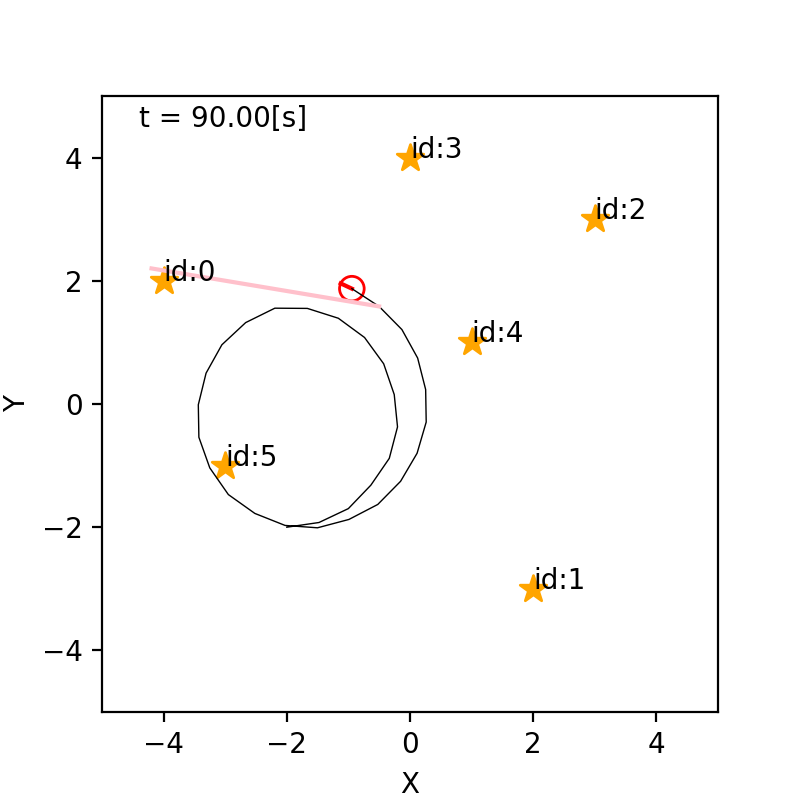

In [3]:
if __name__ == '__main__': 
    time_interval = 3
    world = World(90, time_interval, debug=False) 

    ###真の地図を作成###
    m = Map()
    landmark_positions = [(-4,2), (2,-3), (3,3), (0,4), (1,1), (-3,-1)]
    for p in landmark_positions:
        m.append_landmark(Landmark(*p))
        
    world.append(m) 

    ### ロボットを作る ###
    init_pose = np.array([-2,-2,0]).T
    a = LoggerAgent(0.2, 5.0/180*math.pi, time_interval, init_pose)
    r = Robot(init_pose, sensor=Camera(m), agent=a, color="red")
    world.append(r)

    world.draw()